# Modelling with Linear Regression
ML is built on recurring patterns. One of them is the __linear model__.

We'll cover
* simple LR
* Robust LR
* Hierarchical LR
* Polynomial LR
* Multiple LR
* Interactions
* Variable variance

In [2]:
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from scipy import stats
import pandas as pd

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Simple Linear Regression
Many problems can be stated in the form: we have a variable $x$ and we want to predict from that $y$. The variables are paried up like $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$.

In the simple LR model, bothe x and y and uni-dimensional continuous random variables. $y$ is known as a dependent, predicted or outcome variable, $x$ is the independent, predictor or input variable.

if $x$ is multidimensional (i.e. represetned by a matrix rather than a 1d list), then we have multiple LR.

### Machine Learning
An umbrella term for methods for automatically learning patterns from data, then take decisions. ML has a deep dependency on stats. Some jargon busting:

a regression problem is an example of __supervised learning__. Supervised beacuse we know the X-Y pairs - in effect we know the answer and are trying to generalise rules in the dataset.

__Features__ are put in place of variables.

### Linear regression models
THe familiar equation $y_u = \alpha + x_i \beta$ is at the core of of LR - there is a linear relationship between $x$ and $y$,  with $\beta$ controlling the slope and $\alpha$ the y intercept.

There are several methods for getting to parameters of linear models. One is the __least squares fitting__  to try and find the line which minimises the sum of the square distance between the observations and the line. Alternatively you can think probablistically and generate a probablistic model. This has the advantage that you can get to values for $\alpha$ and $\beta$, but you can also quantify the uncertainty around those values. You can also have more flexibility in how the models are defined.

An LR model can be expressed as 

$$y \sim N(\mu=\alpha+x\beta, \epsilon)$$

with y assumed to have a gaussian distribution with mean $\alpha + \beta x$ and SD $\epsilon$

Se we need to set priors for the parameters

$$\alpha \sim N(\mu_\alpha, \sigma_\alpha)$$

$$\beta \sim N(\mu_\beta, \sigma_\beta)$$

$$\epsilon \sim |N(0, \sigma_\epsilon)$$

And set our $\alpha$ prior to be a very flat normal. For $\beta$ you might have a general idea of the slope and how confident you are on it. $\epsilon$ you can set to be flat over a scale on the variable y. Alternatively for a weak prior for the SD you can set $\epsilon$ to be a uniform or half-cauchy. (The unform less so since it has strict boundaries, and that probably isn't a good reflection of the reality of the situation). For a strong priod for the SD you could use Gamma.

The least squares method will generate a point estimate that agrees with the __maximum a posteriori (MAP)__, the mode of the posterior from a Bayesian simple LR model with flat priors.

Let's build a model for this with some synthetic data

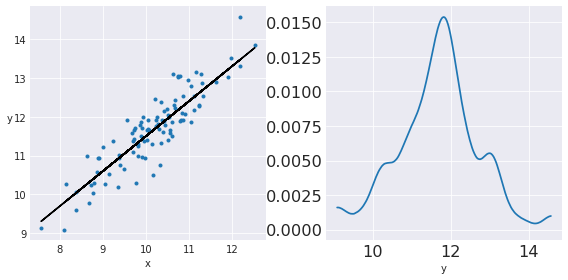

In [2]:
#Data generation
np.random.seed(1)
N = 100
α_real = 2.5
β_real = 0.9
ϵ_real = np.random.normal(0,0.5,size=N)

x = np.random.normal(10,1,N)
y_real = α_real + β_real*x
y = y_real + ϵ_real

_, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(x,y,'C0.')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y', rotation=0)
axes[0].plot(x,y_real,'k')
az.plot_kde(y, ax=axes[1])
axes[1].set_xlabel('y')
plt.tight_layout()
plt.show()

In [3]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α+β*x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    
    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1343.55draws/s]


Note the new object: `Deterministic`. With this we're telling pyMC3 that mu is defined using a formula, not a probablity distribution.

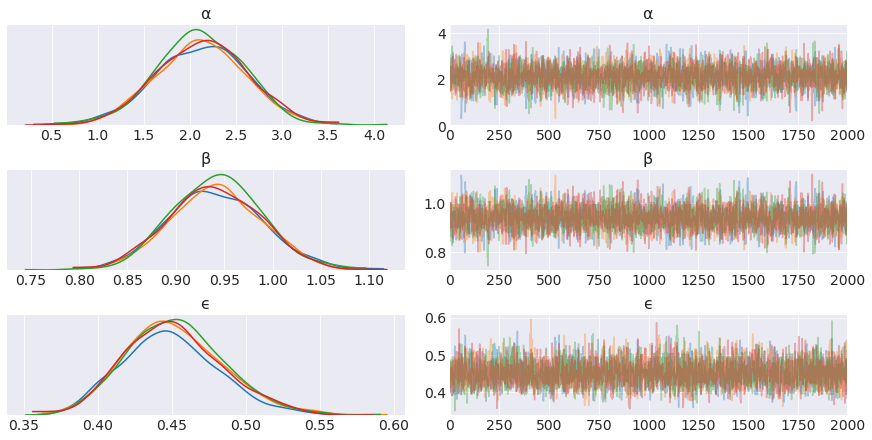

In [4]:
az.plot_trace(trace_g, var_names=['α','β','ϵ'])
plt.show()

### Autocorrelation for linear models

Linear models lead to highly correlated parameter estimates for alpha and beta (see below plot). This is a consequence of our assumptions, that the result is a straight line passing through the center of the data, and changes to parameters 'spin' that line, meaning alpha and beta move in concert. They are _autocorrelated_.

You can mitigate this autocorrelation by normalising x around the mean, $x' = x - \bar{x}$. This has the bonus side effect that your intercept value, y  when x' = 0, is the value of y at the mean of the data, not the arbitrary x=0. More useful. 

Taking this a step further, you can fully standardise the data. This makes things easier for the algorithms, and also means you can use the same weakly informative priors without having to think about the scale of the data.

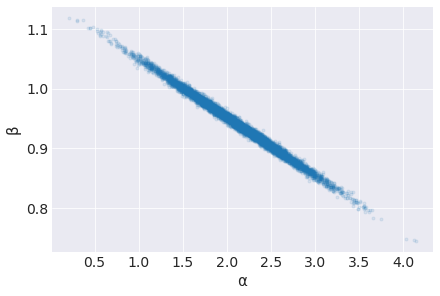

In [5]:
az.plot_pair(trace_g, var_names=['α','β'], plot_kwargs={'alpha':0.1})
plt.show()

### Interpreting the posterior
For LR, you can plot a line over your data with the mean posterior results of alpha and beta, and also plot the sampled lines. Notice that though the range of the sample lines narrows in the middle, they don't all go through a single point.

Alternatively you can plot the HPD as a band. (2nd plot)

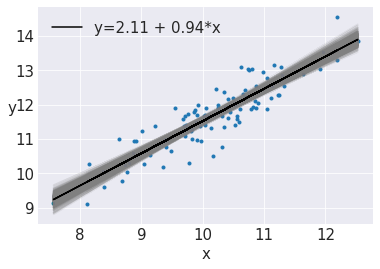

In [6]:
plt.plot(x,y,'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws]+trace_g['β'][draws] 
         * x[:,np.newaxis], c='gray', alpha = 0.1)

plt.plot(x, alpha_m + beta_m * x, c='k',
        label = f'y={alpha_m:.2f} + {beta_m:.2f}*x')

plt.xlabel('x', fontsize=15)
plt.ylabel('y', rotation=0, fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

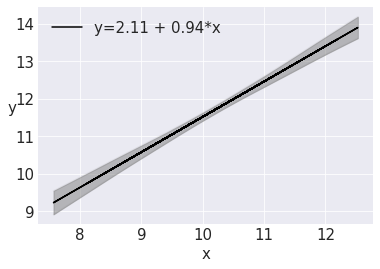

In [7]:
plt.plot(x, alpha_m + beta_m * x, c = 'k',
        label = f'y={alpha_m:.2f} + {beta_m:.2f}*x')
sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='0.5', plot_kwargs={'alpha':0.1})
plt.xlabel('x', fontsize=15)
plt.ylabel('y', rotation=0, fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Another option is to plot the HPD of the posterior predictive.

100%|██████████| 2000/2000 [00:00<00:00, 3391.26it/s]


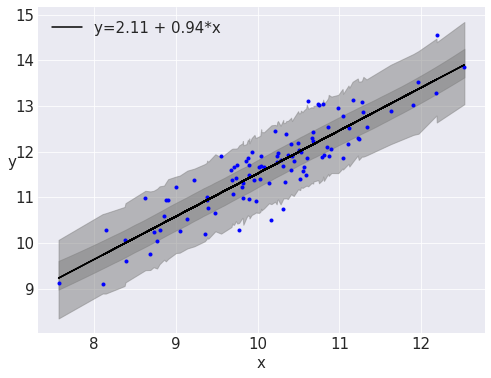

In [8]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)
    
plt.figure(figsize=(8,6))
plt.plot(x,y,'b.')
plt.plot(x, alpha_m + beta_m*x, c='k',
        label = f'y={alpha_m:.2f} + {beta_m:.2f}*x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray')
az.plot_hpd(x, ppc['y_pred'], color='gray', smooth=False) 
# note, plot_hpd is smoothed by default, unsmoothed for illustraion

plt.xlabel('x', fontsize=15)
plt.ylabel('y', rotation=0, fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Correlation coefficient
For measuring the degree of linear dependence between two variables.

The Pearson correlation coefficient $r$ is between -1 and 1. 0 is no correlation, -1 and 1 are perfect correlations in either direction.

Don't confuse $r$ with the slope of the linear regression line. The relationship between the two is

$$r = \beta \frac{\sigma_x}{\sigma_y}$$

i.e. r is equal to the slope $\beta$ only when the standard devations of the variables are the same. That includes when we standardise the data. 

The __Coefficient of determination__ (for a _linear_ regression only) is $r^2$. Conceptually, it is the variance of the predicted values divided by the data, or, the proportion of the variance in the dependent variable which predicted from the independent variable.

Using arviz we can get the r2 value and it's SD

In [9]:
az.r2_score(y, ppc['y_pred'])

r2        0.789426
r2_std    0.006619
dtype: float64

### Pearson with multivariate Gaussian
Another route the Pearson is by estimating the covariance matrix ($\Sigma$) of a multi-variate Gaussian D (which is a generalisation of the Gaussian).

For a bivariate gaussian we need 2 means, but instead of 2 SDs we need a 2x2 matrix, the __covariance matrix__.

$$\Sigma = \begin{bmatrix}
    \sigma_{x1}^2 & \rho\sigma_{x1}\sigma_{x2} \\
    \rho\sigma_{x1}\sigma_{x2} & \sigma_{x2}^2 
    \end{bmatrix}$$
    
What this covariance martix represents is (in the top left and bottom right) the variance of each variable, and (in the TR and BL) the __covariance__, the variance _between_ variables. The covariance is expressed in terms of the SDs of the variables (how spread out they are individually) and of $\rho$, the Pearson correlation coefficient between the variables (how closely correlated they are to eachother.)

Not here we have a single value for $\rho$, because 2 dimensions. For more variables we'll have more.

Let's generate contour plots showing the multivariate mass of two normal distributions $x_1$ and $x_2$, both with means of 0. $x_1$ will have an SD of 1, and we'll show $x_2$ with an SD of either 1 (top row of the plot) or 2 (bottom row). The correlation coefficient $r$ will be various values between -0.9 and 0.9. 

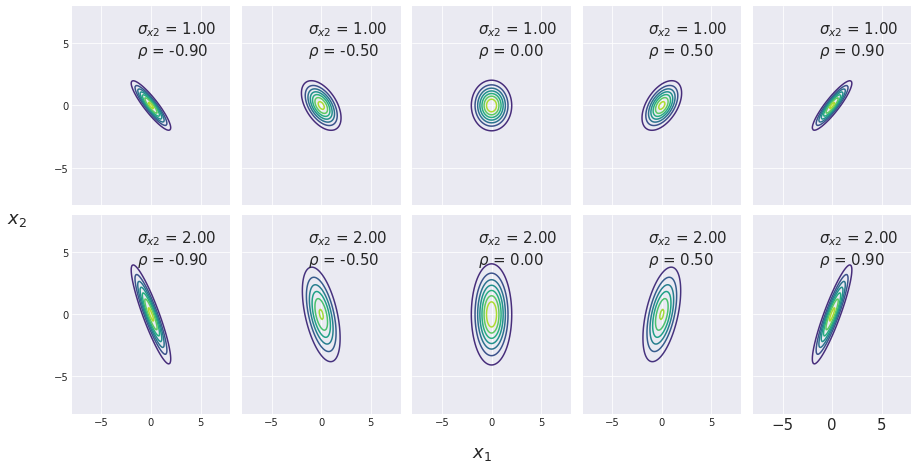

In [10]:
sigma_x1 = 1
sigmas_x2 = [1,2]
rhos = [-0.9, -0.5, 0, 0.5, 0.9]

k, l = np.mgrid[-5:5:0.1, -5:5:0.1] 
# mgrid(x1:y2:s1, x2:y2:s2) creates a dense mesh grid of size x by y in either direction, with step size s  
# k and l are each 2s arrays of 100x100, [[-5. 100 times],[-4.9 100 times],...,[4.9 100 times],[5.0 100 times]]

pos = np.empty(k.shape+(2,)) 
# creates an empty array of specified size. k is a 100x100 array. the + (2,) adds a 3rd dimension, so shape is (100,100,2)
# i.e. a 100x100 grid where each element is a co-ordinate [x,y]

pos[:,:,0] = k
pos[:,:,1] = l
# 

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                    sharex=True, sharey=True, figsize=(12,6),
                    constrained_layout=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], 
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0,0],cov)
        ax[i,j].contour(k, l, rv.pdf(pos), cmap=plt.cm.viridis)
        ax[i,j].set_xlim(-8,8)
        ax[i,j].set_ylim(-8,8)
        ax[i,j].set_yticks([-5,0,5])
        ax[i,j].plot(0,0,
                    label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend(fontsize=15)
f.text(0.5, -0.05, f'$x_1$', ha='center', fontsize=18)
f.text(-0.05, 0.5, f'$x_2$', va='center', fontsize=18, rotation=0)
plt.show()

Let's use a model to estimate the correlation coefficient.

Since we don't know the values to go into the covariance matrix, put priors on the sigmas and rhos which feed into the covarinace, then manually build the cov matrix (there are other ways to do this, like the Wishart or LKJ priors):
* mu ~ Norm(mean=(x_bar, y_bar), sd=10) 
* sigmas 1 and 2 ~ HalfNorm(sd=10)
* rho ~ Uniform(-1,1)
    * r2 = rho**2
    * cov = deterministic on the sigmas and rhos
    * y_pred ~ MVNorm(mu, cov)

In [11]:
data = np.stack((x,y)).T # creates a list of the coordinates [xi,yi]  

with pm.Model() as pearson_model:
    μ = pm.Normal('μ', mu=tuple(data.mean(0)), sd=10, shape=2) # mean(0) returns the means of x and y as a 2x1 array
    
    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1.0, 1.0)
    r2 = pm.Deterministic('r2', ρ**2)
    
    cov = pm.math.stack(((σ_1**2,σ_1*σ_2*ρ),
                        (σ_1*σ_2*ρ,σ_2**2)))
    
    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=tuple(data))
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/joe/miniconda3/envs/bayes/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/joe/miniconda3/envs/bayes/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/joe/miniconda3/envs/bayes/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidime

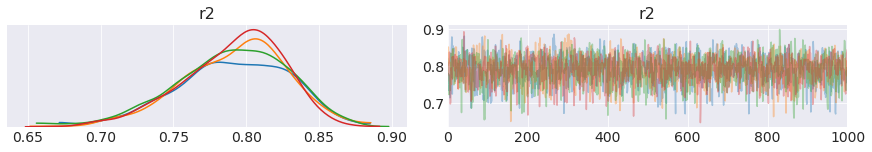

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ[0],10.15,0.09,0.0,9.98,10.33,1870.0,1.0
μ[1],11.67,0.10,0.0,11.48,11.85,1825.0,1.0
σ_1,0.94,0.07,0.0,0.82,1.06,2203.0,1.0
σ_2,1.00,0.07,0.0,0.86,1.13,2146.0,1.0
ρ,0.89,0.02,0.0,0.85,0.93,2403.0,1.0
r2,0.79,0.04,0.0,0.72,0.86,2402.0,1.0


In [12]:
az.plot_trace(trace_p, var_names=['r2'])
plt.show()
az.summary(trace_p)

We get a resulting distribution for r squared which is about 0.8, and an sd of 0.04. Compare this to the result we got from the posterior predictive and you'll see its pretty close.

## Robust LR
We saw earlier that sometimes our assumption of normality fails. We used Student's t to more effectively deal with outliers. We can do the same thing with linear regression.

Let's illustrate this using the 3rd group from the Anscombe quartet

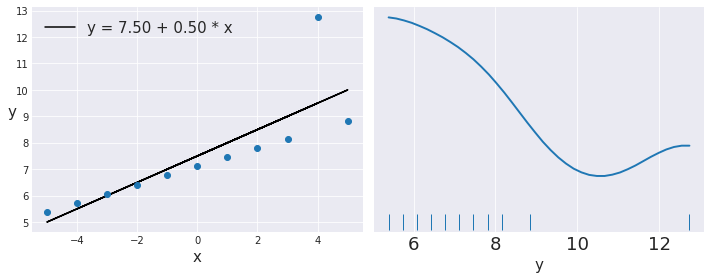

In [13]:
ans = pd.read_csv('data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean() # centering the data

_, ax = plt.subplots(1,2, figsize=(10,4))

beta_c, alpha_c = stats.linregress(x_3, y_3)[:2] # finds the linear regression line, returing tuple (slope, int)
ax[0].plot(x_3, (alpha_c+beta_c*x_3), 'k',
         label=f'y = {alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y',rotation=0, fontsize=15)
ax[0].legend(fontsize=15)

az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_yticks([])
ax[1].set_xlabel('y', fontsize=15)

plt.tight_layout()
plt.show()

Compare the models we get with a normal model and t model

In [14]:
# normal model
with pm.Model() as anscombe3_model_g:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α+β*x_3)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_3)
    
    trace_anscombe_g = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:01<00:00, 5938.30draws/s]


In [15]:
# student t model. Using a shifted exponential for ν to avoid values too close to zero, which you'll recall causes issues.
# other common priors for ν are gamma(2,.1) and gamma(20,15)
with pm.Model() as anscombe3_model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    
    y_pred = pm.StudentT('y_pred', mu=α+β*x_3, sd=ϵ, nu=ν, observed=y_3)
    
    trace_anscombe_t = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:04<00:00, 2598.95draws/s]


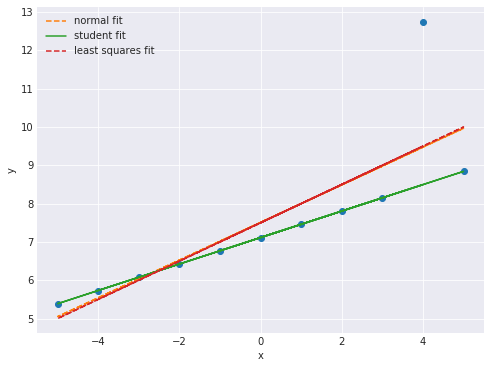

In [16]:
alpha_mean_g = trace_anscombe_g['α'].mean()
beta_mean_g = trace_anscombe_g['β'].mean()

alpha_mean_t = trace_anscombe_t['α'].mean()
beta_mean_t = trace_anscombe_t['β'].mean()

plt.figure(figsize=(8,6))
plt.plot(x_3, y_3, 'o')
plt.plot(x_3, alpha_mean_g + beta_mean_g * x_3, '--', label='normal fit')
plt.plot(x_3, alpha_mean_t + beta_mean_t * x_3, label='student fit')
plt.plot(x_3, alpha_c + beta_c * x_3, '--', label='least squares fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.show()

Again we see that the Student T is more _robust_, because of its fatter tails it assigns less importance to outliers when fitting

Let's take a look at the summary of the t model

In [17]:
az.summary(trace_anscombe_t, var_names = ['α','β','ϵ','ν'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,7.11,0.0,0.0,7.11,7.12,4603.0,1.0
β,0.35,0.0,0.0,0.34,0.35,4660.0,1.0
ϵ,0.00,0.0,0.0,0.00,0.01,3562.0,1.0
ν,1.21,0.2,0.0,1.00,1.58,6664.0,1.0


alpha, beta, and epsilon are very narrowly defined, with standard deviations of 0.0 (epsilon also has a mean of nil). This makes sense given we're fitting  basically a straight line, except for the outlier.

Now lets run ppc

100%|██████████| 200/200 [00:00<00:00, 2260.96it/s]


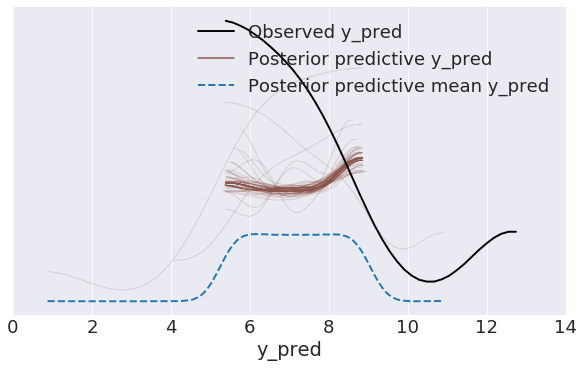

In [18]:
ppc = pm.sample_posterior_predictive(trace_anscombe_t, samples=200,
                                    model=anscombe3_model_t)
data_ppc = az.from_pymc3(trace=trace_anscombe_t, posterior_predictive=ppc)
ax=az.plot_ppc(data_ppc, figsize=(8,5), mean=True)
plt.xlim(0,14)
plt.show()

## Hierarchical LR
We saw hierarchical models in the last chapter. This also can be applied to LR, dealing with inferences at the group level by using hyperpriors.

Lets generate some data

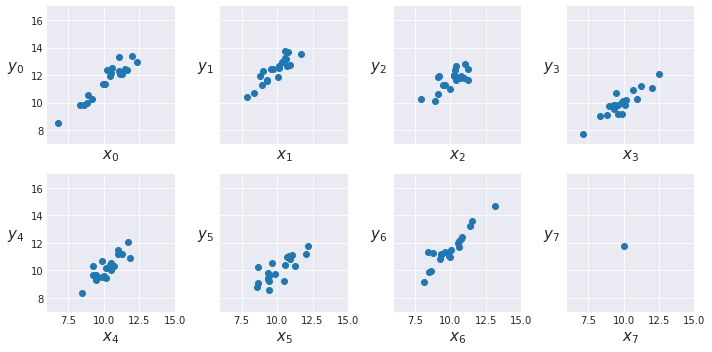

In [4]:
N = 20
M = 8
idx = np.repeat(range(M-1),N)
idx = np.append(idx,7)
np.random.seed(314)

alpha_real = np.random.normal(2.5,0.5,size=M)
beta_real = np.random.beta(6,1,size=M)
eps_real = np.random.normal(0,0.5,size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10,1,len(idx))
y_m = alpha_real[idx]+beta_real[idx]*x_m+eps_real

_,ax = plt.subplots(2,4,figsize=(10,5),
                   sharex=True, sharey=True)
ax = np.ravel(ax)
j,k=0,N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'$x_{i}$', fontsize=15)
    ax[i].set_ylabel(f'$y_{i}$', fontsize=15, rotation=0, labelpad=15)
    ax[i].set_xlim(6,15)
    ax[i].set_ylim(7,17)
    
    j += N
    k += N
plt.tight_layout()
plt.show()

In [6]:
x_centered = x_m - x_m.mean() # center the data before modelling

with pm.Model() as model_unpooled:
    α_tmp = pm.Normal('α_tmp',mu=0,sd=10,shape=M)
    β = pm.Normal('β',mu=0,sd=10,shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx]+β[idx]*x_centered,
                        sd=ϵ, nu=ν, observed=y_m)
    
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    
    trace_model_unpooled = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2624.73draws/s]


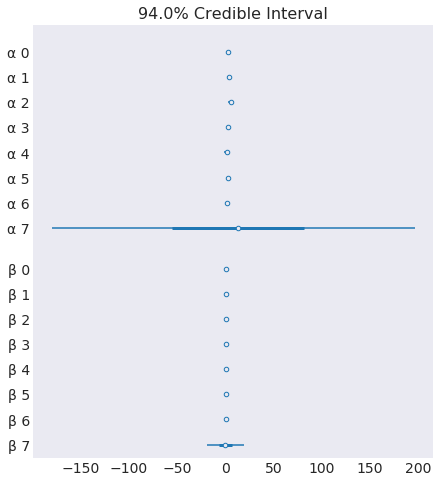

In [7]:
az.plot_forest(trace_model_unpooled, var_names=['α','β'], combined=True)
plt.show()

$\alpha_7$ and $\beta_7$ are very wide compared to the rest, and if you look at the scatter plots you can see why: x7 and y7 contain only 1 point. And you can't fit a line to s single point.

So lets use the same trick that we used before: use hyper parameters to have the parameters be informed by the entire dataset



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:10<00:00, 1578.54draws/s]
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


(<Figure size 432x475.2 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9668fd668>],
       dtype=object))

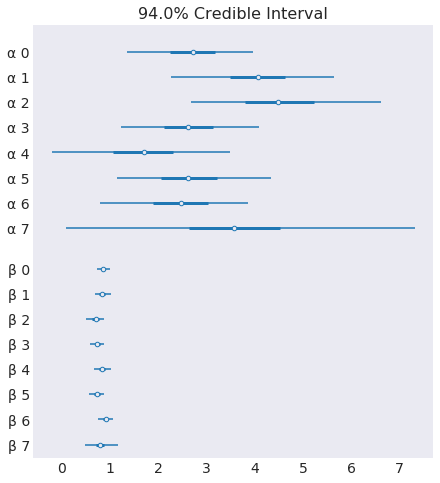

In [10]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred',
                         mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(2000, tune=2000)
    
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

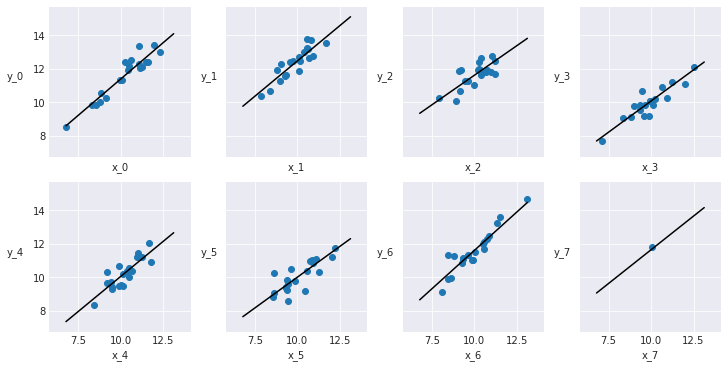

In [11]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.show()

### Correlation, causation and the messiness of life
Suppose we want to know how much we will pay for gas to heat our home. Our bill we will call the dependent variable $y$.

We know the the independent variable, the sun radiation, $x$.

Calling the variables independent and dependent is nothing more than a convention, established relative to our model: our model predicts y from x, which dictates which variable we call dependent. We could equally infer the sun radiation from our bill, in which case the nomenclature would be invesrted. But by saying we infer the sin radiation from our bill, that's not to suggest that the amount of sun radiation is _caused_ by our gas bill, only that it is _correlated_ with it. _correlation does not imply causation_. THe model is separate from the phenomenon. 

A correlation can _support_ a causal link if you design the experiment well, but is not sufficient. For example global warming is correlated with higher CO2 levels. Just from this fact we can't infer which way the causality goes. It could be that there is a third variable which causes both higher temparatures and higher CO2 levels. We can do an experiment to gain some insight. For example you could do an fill glass bottles with air of different CO2 concentrations, expose them to sunlight, and measure the temperatures in the glass bottles. If the resultant temperatures are higher in the bottles which have more CO2, AND the levels of CO2 have not increased in the bottles, we can infer from this that higher CO2 levels create a greenhouse effect, and that temperature does not cause CO2 levels to increase.

Relationships can be more complicated than they appear. For example higher temparatures can evaporate the oceans more quickly, releasing CO2. CO2 is less soluable in water at higher temperatures. So higher temperatures CAN cause increased levels of CO2 in the real world in a way that our experiment didn't allow for.

In short, the real world is messy.

## Polynomial LR

## Multiple LR

## Interactions

## Variable variance